# Interpolation of TOC data for comparison between multiple sites

## Importing needed libraries 

In [11]:
%matplotlib inline
%config IPCompleter.greedy=True
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
password = open('../password.txt', 'r').read()

## Get data from database

#### Connecting to the database

In [12]:
engine = sqlalchemy.create_engine("postgresql://postgres:%s@localhost/MAYHEM" % password)
con = engine.connect()

#### Insert age depth model output and organic data into dataframe

In [13]:
df_model_output = pd.read_sql('modeloutput', con)
df_model_output = df_model_output.sort_values(by = 'measurementid', ignore_index = True)
df_model_output = df_model_output[df_model_output['model_name'] == 'Undatable']
df_organics = pd.read_sql('organic', con)

#### Close the connection to the database

In [14]:
con.close()

## Prepare data for interpolation

#### Merge TOC data with age depth model median output

In [15]:
df_toc = pd.merge(df_organics[['measurementid','toc']],
                                df_model_output[['measurementid', 'modeloutput_median']],
                                how = 'outer',
                                on = ['measurementid'])
df_toc['coreid'],df_toc['compositedepth'] = df_toc['measurementid'].str.split(' ', 1).str
df_toc['compositedepth'] = df_toc['compositedepth'].astype(dtype = float)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """


#### Sort dataframe and remove unnecessary columns and set index to CoreID

In [16]:
df_toc_multiple = df_toc.sort_values(by = ['coreid', 'compositedepth'], ignore_index = True)\
.drop(columns = ['measurementid'])
df_toc_multiple = df_toc_multiple.set_index('coreid')

#### Get a list of unique CoreIDs

In [17]:
List_Unique_CoreID = list(df_toc_multiple.index.unique())

**Individually interpolate (piecewise polynomial) the model output median for the composite depth measurement of TOC for each CoreID, so that every TOC value has a median age\
Then combine each CoreID in one dataframe with the age median as index**

In [18]:
df1 = pd.DataFrame(columns = ['toc'])
for i in List_Unique_CoreID:
    df2 = df_toc_multiple.loc[i]
    df2 = df2.set_index('compositedepth')
    df2 = df2.dropna(how = 'all')
    df2['modeloutput_median'] = df2.modeloutput_median.interpolate('from_derivatives') ## scipy.interpolate.BPoly.from_derivatives
    ### loop to remove NA's
    for j in range(0, len(df2.modeloutput_median)):
        try:
            if np.isnan(df2.iloc[j,1]):
                df2 = df2.drop(df2.index[[j]])
            else:
                pass
        except (IndexError):
            if np.isnan(df2.iloc[-1,1]):
                df2 = df2.drop(df2.index[-1])
            else:
                pass
    ####        
    ### loop to remove big jumps in age-depth model
    for k in range(0,len(df2.index)):
        try:
            if (df2.iloc[k+1,1]- df2.iloc[k,1])/(df2.index[k+1]-df2.index[k]) >= 5000:
                df2 = df2.drop(df2.index[(k+1):-1])
            else:
                pass
        except (IndexError):
            if (df2.iloc[-1,1]- df2.iloc[-2,1])/(df2.index[-1]-df2.index[-2]) >= 5000:
                df2 = df2.drop(df2.index[[-1]])
            else:
                pass
    ####
    df2 = df2.astype({'modeloutput_median': 'int32'})
    df2 = df2.set_index('modeloutput_median')
    df1 = pd.merge(df1, df2, how = 'outer', left_index = True, right_index = True)
### Remove all empty rows and columns
df1 = df1.dropna(how = 'all', axis = 1)
df1 = df1.dropna(how = 'all', axis = 0)
#####
### Rename columns to CoreID
df1.columns = List_Unique_CoreID

#### Remove duplicates in the dataframe

In [19]:
df_combined = df1[~df1.index.duplicated()]

#### Enlarge age median range to a one year resolution

In [20]:
df_combined = df_combined.reindex(range(int(df_combined.index[0]),int(df_combined.index[-1])+1, 1))

#### Piecewise interpolate polynomial the TOC value for now evenly spaced out ages

In [21]:
df_combined_interpolate = df_combined.interpolate('from_derivatives')
df_combined_interpolate = df_combined_interpolate.reset_index()

#### Stack CoreIDs for plotting with age median and TOC value

In [22]:
df_interpolate_TOC = pd.DataFrame()
for i in range(1, len(df_combined_interpolate.columns)):
    df_i_TOC = df_combined_interpolate.iloc[:,[0,i]].dropna(how = 'any') 
    individual_coreid = []
    for k in range(0, len(df_i_TOC)):
        individual_coreid.append(df_i_TOC.columns[1])
    df_i_TOC = df_i_TOC.set_index([individual_coreid])
    df_i_TOC = df_i_TOC.rename(columns = {df_i_TOC.columns[1] : 'toc'})
    df_interpolate_TOC = df_interpolate_TOC.append(df_i_TOC)
df_interpolate_TOC = df_interpolate_TOC.reset_index().rename(columns = {'index' : 'coreid'})

## Plotting the data

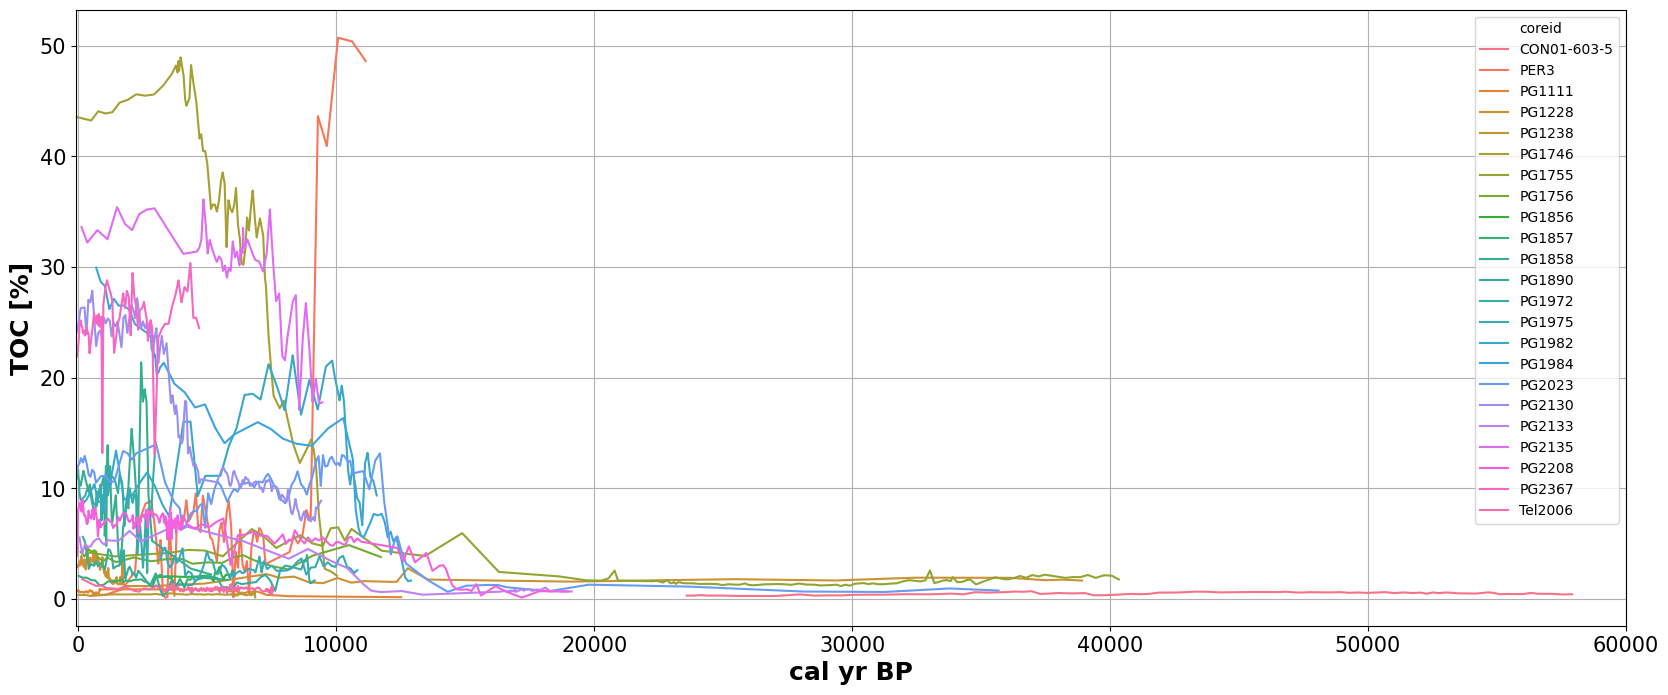

In [23]:
#### Changing the look of the graphic
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 18
plt.rcdefaults()
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
######

fig, ax = plt.subplots(figsize=(20,8))
ax = sns.lineplot(x = 'modeloutput_median', y = 'toc', hue = 'coreid', data = df_interpolate_TOC, legend = 'brief')
plt.legend(loc = 'upper right')
plt.xlim(-100, 60000)
plt.ylabel('TOC [%]', weight = 'bold')
plt.xlabel('cal yr BP', weight = 'bold')
plt.grid(True)
plt.savefig('Figures/TOC_values_interpolated_All_Cores.tiff', dpi = 300, bbox_inches = 'tight')
plt.show()